<b>Исследование синхронизации нейроморфных сетей тесного мира.</b>

Участники:\
    Пеганов Никита\
    Диана Мустаева\
    Роман Головин

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

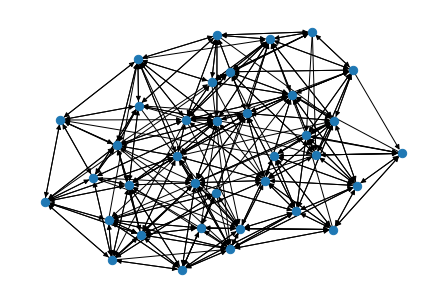

In [35]:
sw = nx.navigable_small_world_graph(6, p=2, q=5)
options = {
#     'node_color': 'black',
    'node_size': 70,
    'width': 1,
}
nx.draw(sw, **options)